# Gibbs free energy expressions for IN625 from ternary CALPHAD DB

This notebook extracts relevant thermodynamic functions necessary for the
phase-field model of solid-state transformations in additively manufactured
superalloy 625, represented as a ternary (Cr-Nb-Ni) with γ, δ, μ, and Laves
phases competing. The thermodynamic database was prepared by U. Kattner after
Du, Liu, Chang, and Yang (2005):

```
@Article{Du2005,
    Title   = {A thermodynamic modeling of the Cr–Nb–Ni system },
    Author  = {Yong Du and Shuhong Liu and Y.A. Chang and Ying Yang},
    Journal = {Calphad},
    Year    = {2005},
    Volume  = {29},
    Number  = {2},
    Pages   = {140 - 148},
    Doi     = {10.1016/j.calphad.2005.06.001}
}
```

This database models the phases of interest as follows:
- γ as $\mathrm{(Cr, Nb, Ni)}$
- δ as $\mathrm{(\mathbf{Nb}, Ni)_1(Cr, Nb, \mathbf{Ni})_3}$
- μ as $\mathrm{Nb_6(Cr, Nb, Ni)_7}$
- Laves as $\mathrm{(\mathbf{Cr}, Nb, Ni)_2(Cr, \mathbf{Nb})_1}$

The phase field model requires Gibbs free energies as functions of system
compositions $x_\mathrm{Cr}$, $x_\mathrm{Nb}$, $x_\mathrm{Ni}$. The Calphad
database represents these energies as functions of sublattice compositions
$y$ in each phase. To avoid solving for internal phase equilibrium at each
point in the simulation, approximations have been made to allow the following
one-to-one mappings between $x$ and $y$:

- γ: no changes necessary
     * $y_\mathrm{Cr}' = x_\mathrm{Cr}$
     * $y_\mathrm{Nb}' = x_\mathrm{Nb}$
     * $y_\mathrm{Ni}' = x_\mathrm{Ni}$
- δ: eliminate Nb from the second (Ni) sublattice, $\mathrm{(\mathbf{Nb}, Ni)_1(Cr, \mathbf{Ni})_3}$
     * $y_\mathrm{Nb}'  = 4x_\mathrm{Nb}$
     * $y_\mathrm{Ni}'  = 1-4x_\mathrm{Nb}$
     * $y_\mathrm{Cr}'' = \frac{4}{3}x_\mathrm{Cr}$
     * $y_\mathrm{Ni}'' = 1-\frac{4}{3}x_\mathrm{Cr}$
     * Constraints: 
         * $x_\mathrm{Nb}\leq\frac{1}{4}$
         * $x_\mathrm{Cr}\leq\frac{3}{4}$
- μ: no changes necessary
     * $y_\mathrm{Nb}'  = 1$
     * $y_\mathrm{Cr}'' = x_\mathrm{Cr}$
     * $y_\mathrm{Nb}'' = \frac{13}{7}x_\mathrm{Nb}-\frac{6}{7}$
     * $y_\mathrm{Ni}'' = x_\mathrm{Ni}$
     * Constraints: 
          * $x_\mathrm{Cr}\leq\frac{7}{13}$ 
          * $x_\mathrm{Nb}\geq\frac{6}{13}$
          * $x_\mathrm{Ni}\leq\frac{7}{13}$
- Laves: eliminate Nb from the first (Cr) sublattice, $\mathrm{(\mathbf{Cr}, Ni)_2(Cr, \mathbf{Nb})_1}$
     * $y_\mathrm{Cr}'  = 1-\frac{3}{2}x_\mathrm{Ni}$
     * $y_\mathrm{Ni}'  = \frac{3}{2}x_\mathrm{Ni}$
     * $y_\mathrm{Cr}'' = 1-3x_\mathrm{Nb}$
     * $y_\mathrm{Nb}'' = 3x_\mathrm{Nb}$
     * Constraints: 
          * $0\leq x_\mathrm{Ni}\leq\frac{2}{3}$
          * $0\leq x_\mathrm{Nb}\leq\frac{1}{3}$

In [1]:
%matplotlib inline
# Numerical libraries
import numpy as np
from scipy.optimize import fsolve
#from scipy.spatial import ConvexHull

# Runtime / parallel libraries
import time, warnings
from itertools import chain
from multiprocessing import Pool

# Visualization libraries
import matplotlib.pylab as plt
from ipywidgets import FloatProgress
from IPython.display import display

from CALPHAD_energies import *

Finished writing paraboloid, Taylor series, and CALPHAD energy functions to disk.
Finished lambdifying Taylor series and CALPHAD energy functions.


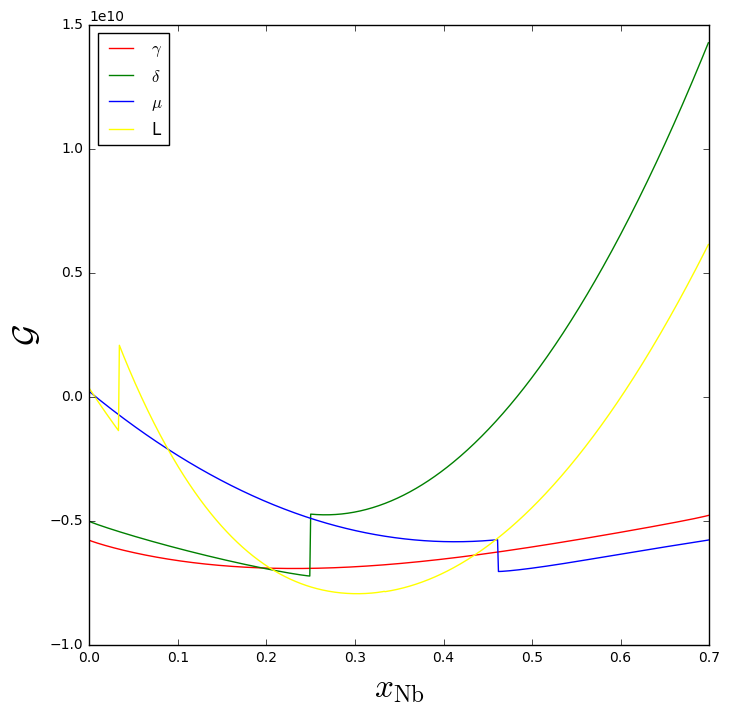

In [2]:
labels = [r'$\gamma$', r'$\delta$', r'$\mu$', 'L']
colors = ['red', 'green','blue', 'yellow']

# plot Gibbs energy curves for fixed x_Cr = 1% to check mu stability
if True:
    xcr = 0.3
    X = []
    G = [[], [], [], []]

    for xnb in np.linspace(epsilon,1,1001):
        xni = 1-xcr-xnb
        if xni>0:
            X.append(xnb)
            G[0].append(GG(xcr, xnb))
            G[1].append(GD(xcr, xnb))
            G[2].append(GU(xcr, xnb))
            G[3].append(GL(xcr, xnb))

    plt.figure(figsize=(8, 8))
    plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    #plt.ylim([-80000, -50000])
    for i in range(len(labels)):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

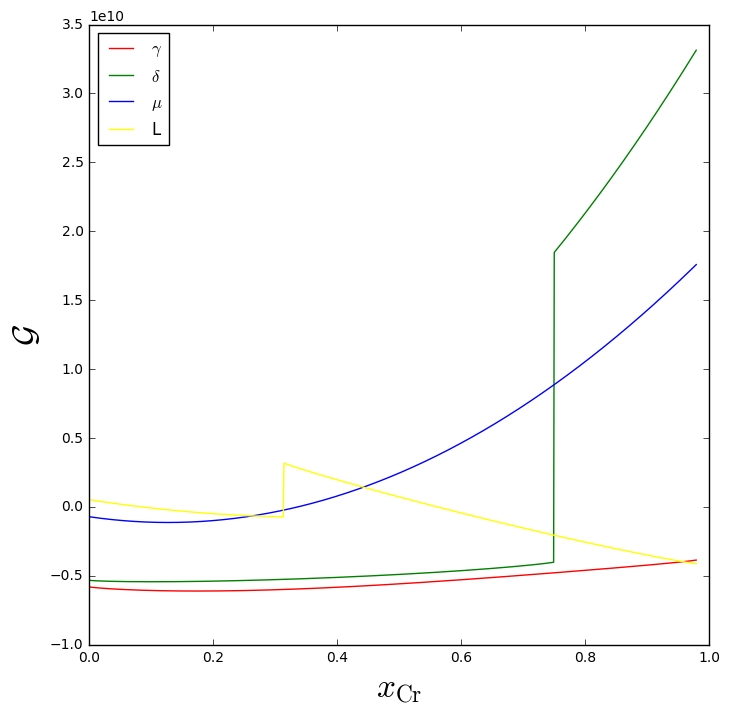

In [3]:
# plot Gibbs energy curves for fixed x_Nb = 15% to check delta stability
if True:
    xnb = 0.02
    X = []
    G = [[], [], [], []]

    for xcr in np.linspace(epsilon,1,1001):
        xni = 1-xcr-xnb
        if xni>0:
            X.append(xcr)
            G[0].append(GG(xcr,xnb))
            G[1].append(GD(xcr,xnb))
            G[2].append(GU(xcr,xnb))
            G[3].append(GL(xcr,xnb))

    plt.figure(figsize=(8, 8))
    plt.xlabel(r'$x_\mathrm{Cr}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    #plt.ylim([-65000, -40000])
    for i in range(len(labels)):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

# Generate a phase diagram

This system has Lagrangian energy density

$$\mathcal{L} = \sum_pn_pG_p - \sum_i\mu_i\left[\sum_pn_px_{p,i} - N_i\right]$$

with phase fraction $n_p$, Gibbs energies (per phase) $G_p$, chemical potentials (per species) $\mu_i$, and mole fractions (per species and per phase) $x_{p,i}$. Note that the $\mu_i$ are the Lagrange multipliers of the constraint of mass conservation.

To generate the phase diagram, this equation is solved for the equilibrium compositions, chemical potentials, and phase fractions, accomplished by setting the partial derivatives of $\mathcal{L}$ with respect to each unknown equal to zero. The $G_p$ are taken from the Calphad database, and $N_i$ are the system composition corresponding to a point on the Gibbs simplex.

Therefore, we have seven knowns:
* 4 from $G$ ($G_\gamma$, $G_\delta$, $G_\mu$, $G_\mathrm{L}$)
* 2 from $N$ ($N_\mathrm{Cr}$, $N_\mathrm{Nb}$)

This leaves nineteen variables: 
* 2 from $\mu$ ($\mu_\mathrm{Cr}$, $\mu_\mathrm{Nb}$)
* 4 from $n$ ($n_\gamma$, $n_\delta$, $n_\mu$, $n_\mathrm{L}$)
* 2 from $x_\gamma$ ($x_{\gamma,\mathrm{Cr}}$, $x_{\gamma,\mathrm{Nb}}$) 
* 2 from $x_\delta$ ($x_{\delta,\mathrm{Cr}}$, $x_{\delta,\mathrm{Nb}}$) 
* 2 from $x_\mu$ ($x_{\mu,\mathrm{Cr}}$, $x_{\mu,\mathrm{Nb}}$)
* 2 from $x_\mathrm{L}$ ($x_{\mathrm{L},\mathrm{Cr}}$, $x_{\mathrm{L},\mathrm{Nb}}$)

The partial derivatives below are taken in exactly the order the variables appear above, producing nineteen equilibrium equations. To accelerate convergence of scipy.optimize.fsolve, the Jacobian matrix $J_{ij}=\frac{\partial f_i}{\partial x_j}$ is also computed -- that is, the partial derivative of each of the nineteen equations is taken with respect to each of the nineteen unknowns, in the same variable order as given above. This makes a $14\times14$ square symmetric matrix of partial derivatives: one equation per row, one variable per column.

## Numerically efficient expressions

In [4]:
# Gibbs energies are already done, ahead of binary Gibbs energy plots
           
# First derivatives
dgdx0 = lambdify((GAMMA_XCR, GAMMA_XNB), dGgam_dxCr.subs({GAMMA_XNI: 1.0-GAMMA_XCR-GAMMA_XNB}), modules='sympy')
dgdx1 = lambdify((GAMMA_XCR, GAMMA_XNB), dGgam_dxNb.subs({GAMMA_XNI: 1.0-GAMMA_XCR-GAMMA_XNB}), modules='sympy')

dddx0 = lambdify((DELTA_XCR, DELTA_XNB), dGdel_dxCr, modules='sympy')
dddx1 = lambdify((DELTA_XCR, DELTA_XNB), dGdel_dxNb, modules='sympy')

dudx0 = lambdify((MU_XCR, MU_XNB), dGmu_dxCr.subs({MU_XNI: 1.0-MU_XCR-MU_XNB}), modules='sympy')
dudx1 = lambdify((MU_XCR, MU_XNB), dGmu_dxNb.subs({MU_XNI: 1.0-MU_XCR-MU_XNB}), modules='sympy')

dldx0 = lambdify((LAVES_XCR, LAVES_XNB), dGlav_dxCr.subs({LAVES_XNI: 1.0-LAVES_XCR-LAVES_XNB}), modules='sympy')
dldx1 = lambdify((LAVES_XCR, LAVES_XNB), dGlav_dxNb.subs({LAVES_XNI: 1.0-LAVES_XCR-LAVES_XNB}), modules='sympy')

# Second derivatives
d2gdxCrCr = lambdify([GAMMA_XCR, GAMMA_XNB], d2Ggam_dxCrCr.subs({GAMMA_XNI: 1.0-GAMMA_XCR-GAMMA_XNB}), modules='sympy')
d2gdxCrNb = lambdify([GAMMA_XCR, GAMMA_XNB], d2Ggam_dxCrNb.subs({GAMMA_XNI: 1.0-GAMMA_XCR-GAMMA_XNB}), modules='sympy')
d2gdxNbCr = lambdify([GAMMA_XCR, GAMMA_XNB], d2Ggam_dxNbCr.subs({GAMMA_XNI: 1.0-GAMMA_XCR-GAMMA_XNB}), modules='sympy')
d2gdxNbNb = lambdify([GAMMA_XCR, GAMMA_XNB], d2Ggam_dxNbNb.subs({GAMMA_XNI: 1.0-GAMMA_XCR-GAMMA_XNB}), modules='sympy')

d2ddxCrCr = lambdify([DELTA_XCR, DELTA_XNB], d2Gdel_dxCrCr, modules='sympy')
d2ddxCrNb = lambdify([DELTA_XCR, DELTA_XNB], d2Gdel_dxCrNb, modules='sympy')
d2ddxNbCr = lambdify([DELTA_XCR, DELTA_XNB], d2Gdel_dxNbCr, modules='sympy')
d2ddxNbNb = lambdify([DELTA_XCR, DELTA_XNB], d2Gdel_dxNbNb, modules='sympy')

d2udxCrCr = lambdify([MU_XCR, MU_XNB], d2Gmu_dxCrCr.subs({MU_XNI: 1.0-MU_XCR-MU_XNB}), modules='sympy')
d2udxCrNb = lambdify([MU_XCR, MU_XNB], d2Gmu_dxCrNb.subs({MU_XNI: 1.0-MU_XCR-MU_XNB}), modules='sympy')
d2udxNbCr = lambdify([MU_XCR, MU_XNB], d2Gmu_dxNbCr.subs({MU_XNI: 1.0-MU_XCR-MU_XNB}), modules='sympy')
d2udxNbNb = lambdify([MU_XCR, MU_XNB], d2Gmu_dxNbNb.subs({MU_XNI: 1.0-MU_XCR-MU_XNB}), modules='sympy')

d2ldxCrCr = lambdify([LAVES_XCR, LAVES_XNB], d2Glav_dxCrCr.subs({LAVES_XNI: 1.0-LAVES_XCR-LAVES_XNB}), modules='sympy')
d2ldxCrNb = lambdify([LAVES_XCR, LAVES_XNB], d2Glav_dxCrNb.subs({LAVES_XNI: 1.0-LAVES_XCR-LAVES_XNB}), modules='sympy')
d2ldxNbCr = lambdify([LAVES_XCR, LAVES_XNB], d2Glav_dxNbCr.subs({LAVES_XNI: 1.0-LAVES_XCR-LAVES_XNB}), modules='sympy')
d2ldxNbNb = lambdify([LAVES_XCR, LAVES_XNB], d2Glav_dxNbNb.subs({LAVES_XNI: 1.0-LAVES_XCR-LAVES_XNB}), modules='sympy')

## Solver

In [5]:
def commonTangentConc(C_Cr, C_Nb, guess):    
    def equilibrium(u0, u1, n0, n1, n2, n3, xg0, xg1, xd0, xd1, xu0, xu1, xl0, xl1):
        Gfcc = GG(xg0, xg1)
        Gdel = GD(xd0, xd1)
        Gmoo = GU(xu0, xu1)
        Glav = GL(xl0, xl1)
        return [# dL/du
                -n0*xg0 - n1*xd0 - n2*xu0 - n3*xl0 + C_Cr,
                -n0*xg1 - n1*xd1 - n2*xu1 - n3*xl1 + C_Nb,
                # dL/dn
                Gfcc - u0*xg0 - u1*xg1,
                Gdel - u0*xd0 - u1*xd1,
                Gmoo - u0*xu0 - u1*xu1,
                Glav - u0*xl0 - u1*xl1,
                # dL/dxg
                dgdx0(xg0,xg1) - u0,
                dgdx1(xg0,xg1) - u1,
                # dL/dxd
                dddx0(xd0,xd1) - u0,
                dddx1(xd0,xd1) - u1,
                # dL/dxu
                dudx0(xu0,xu1) - u0,
                dudx1(xu0,xu1) - u1,
                # dL/dxl
                dldx0(xl0,xl1) - u0,
                dldx1(xl0,xl1) - u1
                ]

    def Equilibrium(A):
        # Helper to convert from an array to named input
        return equilibrium(A[0], A[1], A[2], A[3], A[4], A[5], A[6], A[7], A[8], A[9], A[10], A[11], A[12], A[13])

    def jacobian(u0, u1, n0, n1, n2, n3, xg0, xg1, xd0, xd1, xu0, xu1, xl0, xl1):
        return[
            [0,0,-xg0,-xd0,-xu0,-xl0,-n0,0,-n1,0,-n2,0,-n3,0],
            [0,0,-xg1,-xd1,-xu1,-xl1,0,-n0,0,-n1,0,-n2,0,-n3],
            
            [-xg0,-xg1,0,0,0,0, dgdx0(xg0,xg1)-u0,dgdx1(xg0,xg1)-u1,0,0,0,0,0,0],
            [-xd0,-xd1,0,0,0,0, 0,0,dddx0(xd0,xd1)-u0,dddx1(xd0,xd1)-u1,0,0,0,0],
            [-xu0,-xu1,0,0,0,0, 0,0,0,0,dudx0(xu0,xu1)-u0,dudx1(xu0,xu1)-u1,0,0],
            [-xl0,-xl1,0,0,0,0, 0,0,0,0,0,0,dldx0(xl0,xl1)-u0,dldx1(xl0,xl1)-u1],
            [-1,0,dgdx0(xg0,xg1)-u0,0,0,0, n0*d2gdxCrCr(xg0,xg1),n0*d2gdxCrNb(xg0,xg1),0,0,0,0,0,0],
            [0,-1,dgdx1(xg0,xg1)-u1,0,0,0, n0*d2gdxCrNb(xg0,xg1),n0*d2gdxNbNb(xg0,xg1),0,0,0,0,0,0],
            [-1,0,0,dddx0(xd0,xd1)-u0,0,0, 0,0,n1*d2ddxCrCr(xd0,xd1),n1*d2ddxCrNb(xd0,xd1),0,0,0,0],
            [0,-1,0,dddx1(xd0,xd1)-u1,0,0, 0,0,n1*d2ddxCrNb(xd0,xd1),n1*d2ddxNbNb(xd0,xd1),0,0,0,0],
            [-1,0,0,0,dudx0(xu0,xu1)-u0,0, 0,0,0,0,n2*d2udxCrCr(xu0,xu1),n2*d2udxCrNb(xu0,xu1),0,0],
            [0,-1,0,0,dudx1(xu0,xu1)-u1,0, 0,0,0,0,n2*d2udxCrNb(xu0,xu1),n2*d2udxNbNb(xu0,xu1),0,0],
            [-1,0,0,0,0,dldx0(xl0,xl1)-u0, 0,0,0,0,0,0,n3*d2ldxCrCr(xl0,xl1),n3*d2ldxCrNb(xl0,xl1)],
            [0,-1,0,0,0,dldx1(xl0,xl1)-u1, 0,0,0,0,0,0,n3*d2ldxCrNb(xl0,xl1),n3*d2ldxNbNb(xl0,xl1)]
        ]

    def Jacobian(A):
        return jacobian(A[0], A[1], A[2], A[3], A[4], A[5], A[6], A[7], A[8], A[9], A[10], A[11], A[12], A[13])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return fsolve(func=Equilibrium, x0=guess, fprime=Jacobian)


In [6]:
def computeKernel(n):
    r = n / density
    xnb = (r + epsilon) / (density-1)
    s = n - r * density
    xcr = (s + epsilon) / (density-1)
    xni = 1 - xcr - xnb

    if xni > 0:
        # Initial condition for gamma-delta coexistence field

#     guessA = (1.0, 1.0,   1.0,        # Cr, Nb, Ni potentials
#              0.5-epsilon, 0.5-epsilon, epsilon,epsilon,# gamma, delta, mu, bcc fractions
#              xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9), 0.9, # gamma comp
#              xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), 0.75, # delta comp
#              0.01, 0.525, 0.465,    # mu comp
#              xcr/(xcr+xnb), xnb/(xcr+xnb), epsilon) # bcc comp

#     # Initial condition for delta-mu coexistence field
#     guessB = (1.0, 1.0,   1.0,        # Cr, Nb, Ni potentials
#              epsilon, 0.475, 0.475, 0.05-epsilon,# gamma, delta, mu, bcc fractions
#              xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9), 0.9, # gamma comp
#              xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), 0.75, # delta comp
#              0.01, 0.525, 0.465,    # mu comp
#              xcr/(xcr+xnb), xnb/(xcr+xnb),  epsilon) # bcc comp

#     # Initial condition for mu-Laves coexistence field
#     guessC = (1.0,  1.0,  1.0,        # Cr, Nb, Ni potentials
#              epsilon,0.05-epsilon, 0.475, 0.475,# gamma, delta, mu, bcc fractions
#              xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9), 0.9, # gamma comp
#              xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), 0.75, # delta comp
#              0.01, 0.525, 0.465,    # mu comp
#              xcr/(xcr+xnb), xnb/(xcr+xnb),  epsilon) # bcc comp

#     # Initial condition for delta-Laves coexistence field
#     guessD = (1.0,  1.0,  1.0,        # Cr, Nb, Ni potentials
#              epsilon, 0.475, 0.05-epsilon, 0.475,# gamma, delta, mu, bcc fractions
#              xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9), 0.9, # gamma comp
#              xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), 0.75, # delta comp
#              0.01, 0.525, 0.465,    # mu comp
#              xcr/(xcr+xnb), xnb/(xcr+xnb),  epsilon) # bcc comp

#     # Initial condition for delta-mu-Laves coexistence field
#     guessE = (1.0, 1.0,   1.0,        # Cr, Nb, Ni potentials
#              epsilon, 0.34-epsilon, 0.33, 0.33,# gamma, delta, mu, bcc fractions
#              xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9), 0.9, # gamma comp
#              xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), 0.75, # delta comp
#              0.01, 0.525, 0.465,    # mu comp
#              xcr/(xcr+xnb), xnb/(xcr+xnb),  epsilon) # bcc comp
    
    
        # Choose an appropriate guess for this composition region
        guess = (1.0, 1.0, # Cr, Nb, Ni potentials
             epsilon, 0.34-epsilon, 0.33, 0.33,# gamma, delta, mu, bcc fractions
             xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9),# gamma comp
             xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), # delta comp
             0.025, 0.4875,    # mu comp
             xcr/(xcr+xnb), xnb/(xcr+xnb)) # bcc comp  

        if xni > 0.725:
            # gamma-delta coexistence, field A
            guess = (1.0, 1.0,     # Cr, Nb, Ni potentials
             0.5-epsilon, 0.5-epsilon, epsilon,epsilon,# gamma, delta, mu, bcc fractions
             xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9),# gamma comp
             xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), # delta comp
             0.025, 0.4875,   # mu comp
             xcr/(xcr+xnb), xnb/(xcr+xnb),) # bcc comp
        elif xcr<0.025+(0.45/0.025)*(xnb-0.5):
            # mu-Laves coexistence, field C
            guess = (1.0,  1.0,     # Cr, Nb, Ni potentials
             epsilon,0.05-epsilon, 0.475, 0.475,# gamma, delta, mu, bcc fractions
             xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9),# gamma comp
             xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), # delta comp
             0.025, 0.4875,   # mu comp
             xcr/(xcr+xnb), xnb/(xcr+xnb)) # bcc comp
        elif xcr<0.025*(xnb-0.225)/0.225:
            # delta-mu coexistence, field B
            guess = (1.0, 1.0,      # Cr, Nb, Ni potentials
             epsilon, 0.475, 0.475, 0.05-epsilon,# gamma, delta, mu, bcc fractions
             xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9),  # gamma comp
             xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), # delta comp
             0.025, 0.4875,  # mu comp
             xcr/(xcr+xnb), xnb/(xcr+xnb)) # bcc comp
        elif xcr>0.475*(xnb-0.25)/(0.525-0.25):
            # delta-Laves coexistence, field D
            guess = (1.0,  1.0,     # Cr, Nb, Ni potentials
             epsilon, 0.475, 0.05-epsilon, 0.475,# gamma, delta, mu, bcc fractions
             xcr/(xcr+xnb+0.9), xnb/(xcr+xnb+0.9), # gamma comp
             xcr/(xcr+xnb+0.75), xnb/(xcr+xnb+0.75), # delta comp
             0.025, 0.4875,    # mu comp
             xcr/(xcr+xnb), xnb/(xcr+xnb)) # bcc comp

        # Solve the common tangent construction
        result = [xcr, xnb]        
        tangent = commonTangentConc(xcr, xnb, guess)
        for i in tangent:
            result.append(i)
        return result
    else:
        return [0]*16

In [28]:
# triangle bounding the Gibbs simplex
tielines = []

XG = [] # array of Cr concentrations
YG = [] # array of Nb concentrations
XD = [] # (gamma, delta, mu, bcc)
YD = []
XU = []
YU = []
XL = []
YB = [] 

# Plot domains corresponding to the test points
RXA = []
RYA = []
RXL = []
RYB = []
RXC = []
RYC = []
RXD = []
RYD = []
RXE = []
RYE = []

density = 101
threshold = 0.95

if __name__ == '__main__':
    starttime = time.time() # not exact, but multiprocessing makes time.clock() read from different cores

    bar = FloatProgress(min=0,max=density**2) #(density-1)/2) 
    display(bar)

    pool = Pool(12)

    m = 0
    for result in pool.imap(computeKernel, range(density**2)):
        xcr,   xnb, \
        equ0,  equ1,\
        eqn0,  eqn1,  eqn2, eqn3, \
        eqxg0, eqxg1,  \
        eqxd0, eqxd1,  \
        eqxu0, eqxu1,  \
        eqxl0, eqxl1 = result

        if xni+epsilon > 0:
            # Store points for the phase diagram
            nsum = eqn0 + eqn1 + eqn2 + eqn3
            if nsum > threshold:
                # Store points corresponding to initial guess domains
                if xni > 0.725:
                    # gamma-delta coexistence, field A
                    RXA.append(simX(xnb, xcr))
                    RYA.append(simY(xcr))
                elif xcr<0.025+(0.45/0.025)*(xnb-0.5):
                    # mu-Laves coexistence, field C
                    RXC.append(simX(xnb, xcr))
                    RYC.append(simY(xcr))
                elif xcr<0.025*(xnb-0.225)/0.225:
                    # delta-mu coexistence, field B
                    RXL.append(simX(xnb, xcr))
                    RYB.append(simY(xcr))
                elif xcr>0.475*(xnb-0.25)/(0.525-0.25):
                    # delta-Laves coexistence, field D
                    RXD.append(simX(xnb, xcr))
                    RYD.append(simY(xcr))
                else:
                    # delta-mu-Laves coexistence, field E
                    RXE.append(simX(xnb, xcr))
                    RYE.append(simY(xcr))

                # Store equilibrium compositions
                ties = []


                xgsum = eqxg0+eqxg1
                xdsum = eqxd0+eqxd1
                xusum = eqxu0+eqxu1
                xlsum = eqxl0+eqxl1

                #if eqxd0+epsilon>0 and eqxd1+epsilon>0 and eqxd2+epsilon>0 and eqxd2-epsilon<1:
                #if eqxg0+epsilon>0 and eqxg1+epsilon>0 and xgsum-epsilon<1 and xgsum+epsilon>0:
                if eqxg0+epsilon>0 and eqxg1+epsilon>0 and 1-eqxg0-eqxg1>0:
                    XG.append(simX(eqxg1,eqxg0))
                    YG.append(simY(eqxg0))
                    ties.append([simX(eqxg1,eqxg0), simY(eqxg0)])

                #if eqxd0+epsilon>0 and eqxd1+epsilon>0 and xdsum-epsilon<1 and xdsum+epsilon>0:
                if eqxd0+epsilon>0 and eqxd1+epsilon>0 and 1-eqxd0-eqxd1>0:
                    XD.append(simX(eqxd1,eqxd0))
                    YD.append(simY(eqxd0))
                    ties.append([simX(eqxd1,eqxd0), simY(eqxd0)])

                #if eqxu0+epsilon>0 and eqxu1+epsilon>0 and xusum-epsilon<1 and xusum+epsilon>0:
                if eqxu0+epsilon>0 and eqxu1+epsilon>0 and 1-eqxu0-eqxu1>0:
                    XU.append(simX(eqxu1,eqxu0))
                    YU.append(simY(eqxu0))
                    ties.append([simX(eqxu1,eqxu0), simY(eqxu0)])

                #if eqxl0+epsilon>0 and eqxl1+epsilon>0 and xlsum-epsilon<1 and xlsum+epsilon>0:
                if eqxl0+epsilon>0 and eqxl1+epsilon>0 and 1-eqxl0-eqxl1>0:
                    XL.append(simX(eqxl1,eqxl0))
                    YB.append(simY(eqxl0))
                    ties.append([simX(eqxl1,eqxl0), simY(eqxl0)])
                
                tielines.append(ties)
        m += 1
        bar.value = m

    pool.close()
    
    runtime = time.time() - starttime
    print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:5m:44s elapsed


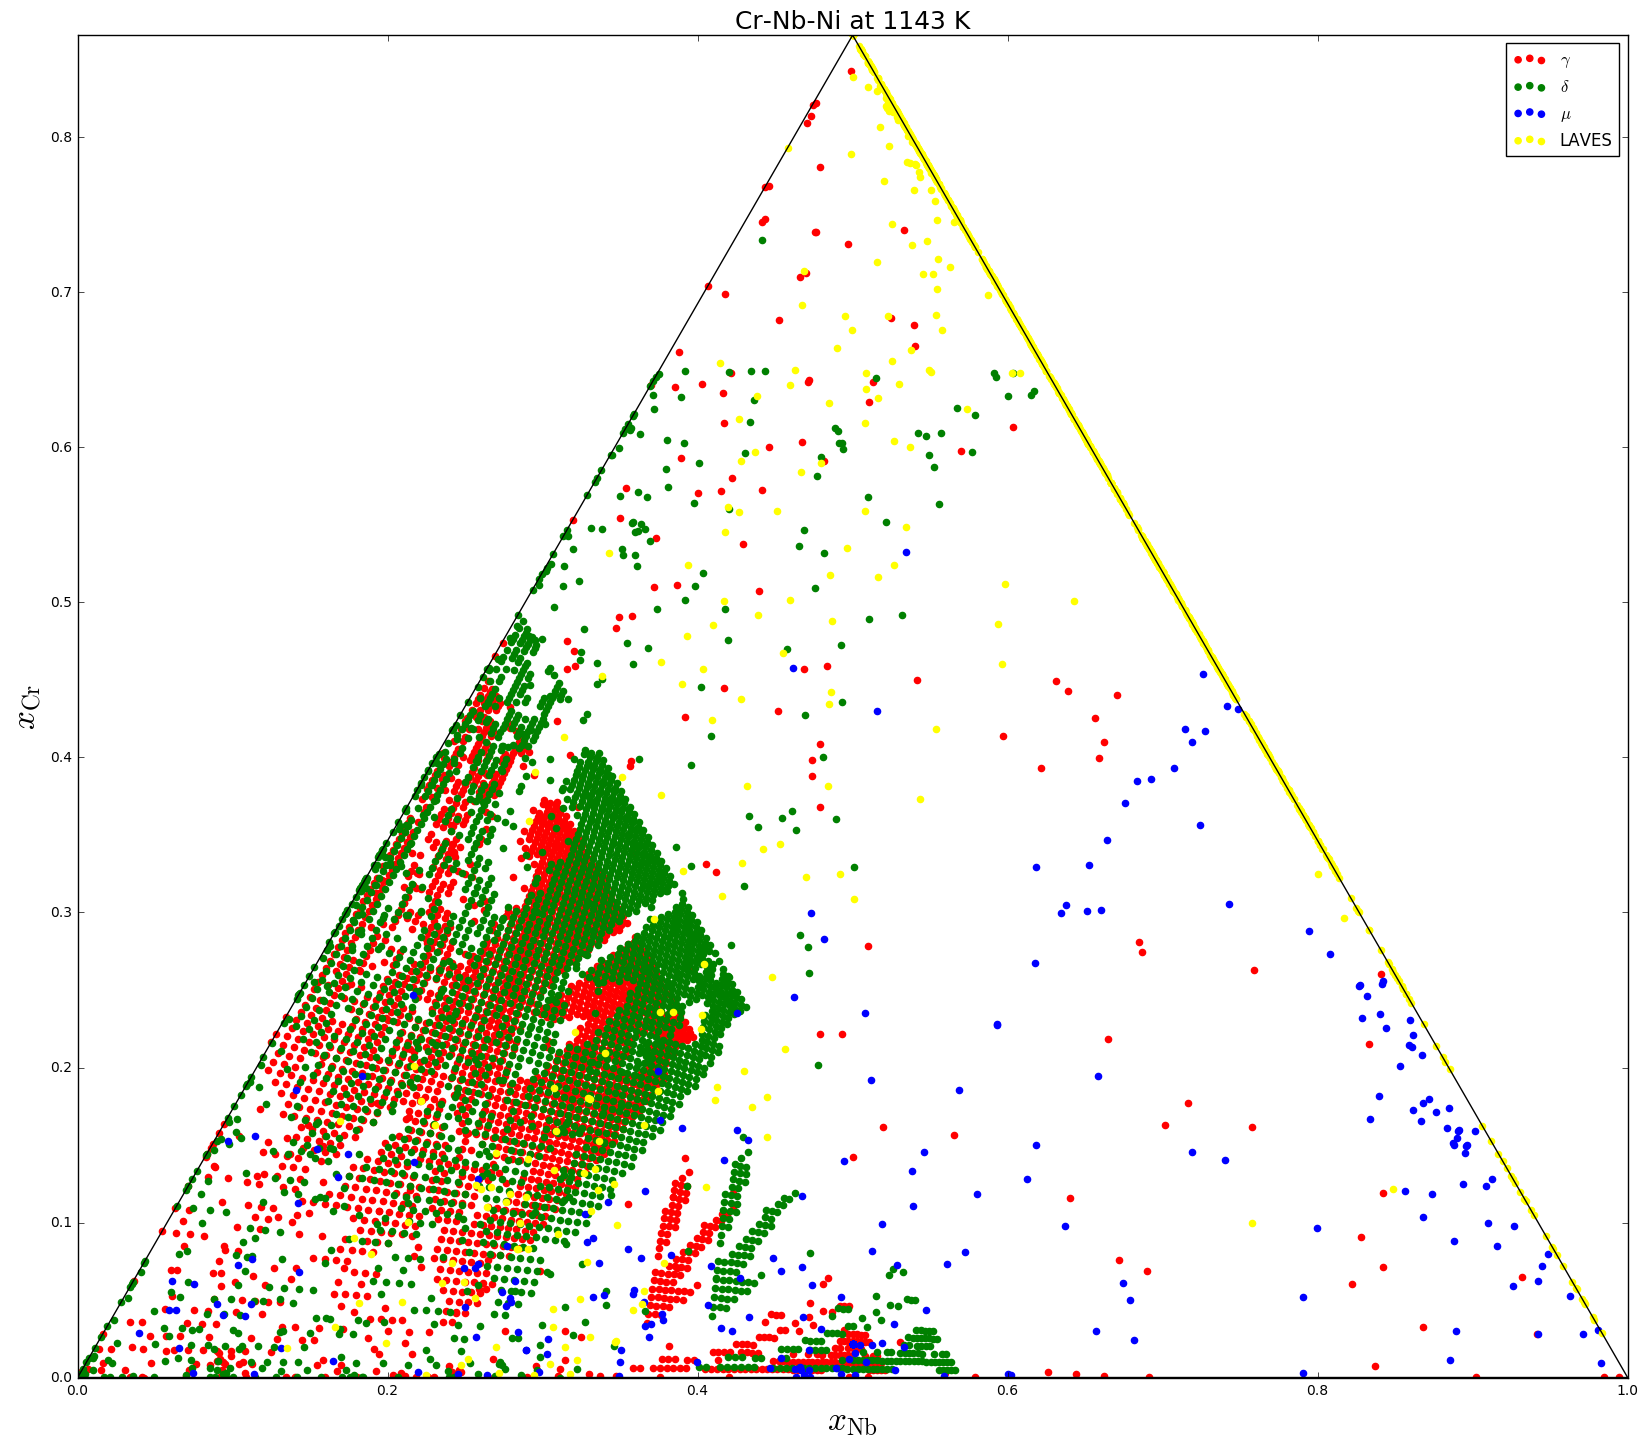

In [29]:
# Plot filtered phase compositions
pltsize = 20
plt.figure(figsize=(pltsize, rt3by2*pltsize))
plt.title("Cr-Nb-Ni at %.0f K"%temp, fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt3by2])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Cr}$', fontsize=24)
plt.plot(XS, YS, '-k')
plt.scatter(XG, YG, color='red',   label=r'$\gamma$')
plt.scatter(XD, YD, color='green', label=r'$\delta$')
plt.scatter(XU, YU, color='blue',  label=r'$\mu$')
plt.scatter(XL, YB, color='yellow',label='LAVES')
plt.legend(loc='best')
plt.show()

In [ ]:
# # Plot domains corresponding to the test points
# plt.figure(figsize=(pltsize, rt3by2*pltsize))
# plt.title("Guess Domains", fontsize=18)
# plt.xlim([0,1])
# plt.ylim([0,rt3by2])
# plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
# plt.ylabel(r'$x_\mathrm{Cr}$', fontsize=24)
# plt.plot(XS, YS, '-k')
# plt.scatter(RXA, RYA, color='red',    s=2, label=r'A ($\gamma-\delta$)')
# plt.scatter(RXL, RYB, color='green',  s=2, label=r'B ($\gamma-\mu$)')
# plt.scatter(RXC, RYC, color='blue',   s=2, label=r'C ($\mu-$LAVES)')
# plt.scatter(RXD, RYD, color='yellow', s=2, label=r'D ($\delta-$LAVES)')
# plt.scatter(RXE, RYE, color='magenta',s=2, label=r'E ($\delta-\mu-$LAVES)')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# # Plot with tie lines
# pltsize = 20
# plt.figure(figsize=(pltsize, rt3by2*pltsize))
# plt.title("Cr-Nb-Ni at %.0f K"%temp, fontsize=18)
# plt.xlim([0,1])
# plt.ylim([0,rt3by2])
# plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
# plt.ylabel(r'$x_\mathrm{Cr}$', fontsize=24)
# for line in tielines:
#     for i in range(len(line)):
#         for j in range(len(line)):
#             if i==j:
#                 pass
#             plt.plot((line[i][0],line[j][0]), (line[i][1],line[j][1]), '-k', alpha=0.01)
# plt.plot(XS, YS, '-k')
# plt.scatter(XG, YG, color='red',   label=r'$\gamma$')
# plt.scatter(XD, YD, color='green', label=r'$\delta$')
# plt.scatter(XU, YU, color='blue',  label=r'$\mu$')
# plt.scatter(XL, YB, color='yellow',label='LAVES')
# plt.legend(loc='best')
# plt.show()

## Mobility

In [ ]:
if True:
    def mob_Cr(x, y):
        return (8.8e-5 * np.exp(-257000/(8.3144598 * temp))) / (1.e-5 * d2gdxCrCr(x,y))
    def mob_Nb(x, y):
        return (1.15e-4 * np.exp(-281000/(8.3144598 * temp))) / (1.e-5 * d2gdxNbNb(x,y))

    XM = []
    YCr = []
    YNb = []

    for xni in np.linspace(0.01,1,101):
        bestCr = 1.25
        bestNb = 1.25
        for xnb in np.linspace(0.01,1,101):
            xcr = 1.0 - xni - xnb
            if xcr>epsilon:
                mcr = mob_Cr(xcr,xnb)
                mnb = mob_Nb(xcr,xnb)
                if (mcr<bestCr):
                    bestCr = mcr
                if (mnb<bestNb):
                    bestNb = mnb
        if bestCr < 1.0:
            XM.append(xni)
            YCr.append(np.log(float(bestCr)))
            YNb.append(np.log(float(bestNb)))
                
    plt.plot(XM, YCr, label="Cr", color='red')
    plt.plot(XM, YNb, label="Nb", color='blue')
    plt.show()
    
    print "Max: ", np.max(YCr), np.max(YNb)
    print "Min: ", np.min(YCr), np.min(YNb)
    print "Avg: ", np.mean(YCr), np.mean(YNb)

In [ ]:
print "Avg. M_Cr:", np.exp(np.mean(YCr))
print "Avg. M_Nb:", np.exp(np.mean(YNb))